In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

import tensorflow as tf
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler

2022-02-25 15:25:17.848659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 15:25:17.848678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Train set size:", x_train.shape, y_train.shape)
print("Test set size:",  x_test.shape, y_test.shape)
print("Class with counts: ",np.unique(y_train, return_counts=True))

# splitting the train data into train and validation. validation set is 10% (approx 6000) of the original train set
# x_val = x_train[:6000]
# y_val = y_train[:6000]
# x_train = x_train[6000:]
# y_train = y_train[6000:]

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)


print("Class with counts: ", np.unique(y_train, return_counts=True))
print("Training set size:", x_train.shape, y_train.shape)
print("Validation set size:", x_val.shape, y_val.shape)


11501568/11490434 [==============================] - 1s 0us/step


Train set size:
(60000, 28, 28)
(60000,)

Test set size:
(10000, 28, 28)
(10000,)

Class with counts: 
(
    array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
    array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
)

Class with counts: 
(
    array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
    array([5331, 6068, 5362, 5518, 5258, 4879, 5326, 5638, 5266, 5354])
)

Training set size:
(54000, 28, 28)
(54000,)

Validation set size:
(6000, 28, 28)
(6000,)

# Plotting example data

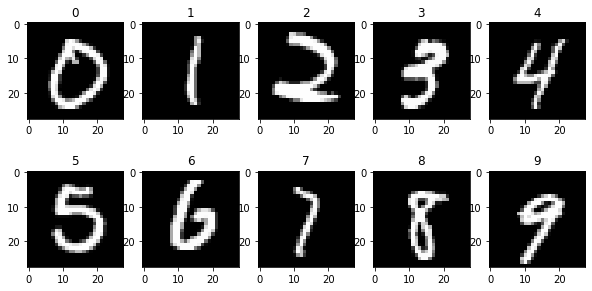

In [3]:
class_names = ['0', '1', '2', '3', '4','5','6', '7', '8', '9']


# finding example of all classes
example_images = {}
for i in range(len(x_train)):
    if len(example_images) == 10:
        break
    if y_train[i] not in example_images.keys():
        example_images[y_train[i]] = x_train[i]

# plotting the images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
# ax is a 2x5 array of axes
for i in range(10):
    ax[i//5, i % 5].imshow(example_images[i], cmap="gray")
    ax[i//5, i % 5].set_title(class_names[i])


# Importing NN Module

In [5]:
from NN.Model import Model
from NN.Layer.Linear import Linear
from NN.Layer.Activation.ReLU import ReLU
from NN.Layer.Activation.TanH import TanH
from NN.Layer.Activation.Sigmoid import Sigmoid
from NN.Layer.Activation.Softmax import Softmax
from NN.Accuracy.Accuracy import Accuracy
from NN.Loss.CategoricalCrossEntropy import CategoricalCrossEntropy
from NN.Optimizer.Adam import Adam
from NN.Optimizer.Nadam import Nadam
from NN.Optimizer.RMSprop import RMSprop
from NN.Optimizer.Momentum import Momentum
from NN.Optimizer.SGD import SGD
from NN.Optimizer.NAG import NAG

import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

import wandb
import os

# os.environ["WANDB_SILENT"] = "true"
wandb.init(project="Assignment1", entity="cookie303")
wandb.log({"examples": fig})

wandb: Currently logged in as: ms20 (use `wandb login --relogin` to force relogin)
2022-02-25 15:27:15.467876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 15:27:15.467903: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Pre-processing

In [6]:
def do_standard_transform(X, scalar=None):
    X = X.reshape(X.shape[0], -1).astype("float32")
    
    # Or do sklearn's StandardScaler
    if scalar is not None:
        X = scalar.transform(X)
    else:
        X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

    return X


def do_one_hot_encode(y, encoder=None):
    y = y.reshape(-1, 1)
    if encoder is not None:
        y = encoder.transform(y).toarray()
    else:
        encoder = OneHotEncoder()
        encoder.fit(y)
        y = encoder.transform(y).toarray()
    return y


X      = do_standard_transform(x_train)
X_val  = do_standard_transform(x_val)
X_test = do_standard_transform(x_test)

# One hot encoding the labels
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))


y_train_one_hot = do_one_hot_encode(y_train, enc)
y_val_one_hot = do_one_hot_encode(y_val, enc)
y_test_one_hot = do_one_hot_encode(y_test, enc)

In [7]:
# wandb.init(project="Assignment1", entity="cookie303")

# wandb.config = {
#     "learning_rate": 0.001,
#     "epochs": 100,
#     "batch_size": 128
# }


# Instantiate the model
model = Model()

# Add layers
model.add(Linear(X.shape[1], 32, initializer="xavier"))
model.add(TanH())
model.add(Linear(32, 32, initializer="xavier"))
model.add(TanH())
model.add(Linear(32, 10, initializer="random"))
model.add(Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=CategoricalCrossEntropy(),
    optimizer=Adam(learning_rate=1e-3),
    # optimizer=SGD(learning_rate=0.01, momentum=0.09),
    scoring=Accuracy()
)

# Finalize the model
model.setup_connections()

# Train the model
model.train(X, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
            epochs=10, batch_size=16)

epoch=1
training_loss=0.35, training_accuracy= 0.90
Validation: val_loss=0.22, val_accuracy=0.94

epoch=2
training_loss=0.20, training_accuracy= 0.94
Validation: val_loss=0.20, val_accuracy=0.94

epoch=3
training_loss=0.17, training_accuracy= 0.95
Validation: val_loss=0.20, val_accuracy=0.94

epoch=4
training_loss=0.15, training_accuracy= 0.95
Validation: val_loss=0.19, val_accuracy=0.94

epoch=5
training_loss=0.14, training_accuracy= 0.96
Validation: val_loss=0.17, val_accuracy=0.95

epoch=6
training_loss=0.13, training_accuracy= 0.96
Validation: val_loss=0.17, val_accuracy=0.95

epoch=7
training_loss=0.13, training_accuracy= 0.96
Validation: val_loss=0.18, val_accuracy=0.95

epoch=8
training_loss=0.12, training_accuracy= 0.96
Validation: val_loss=0.16, val_accuracy=0.96

epoch=9
training_loss=0.11, training_accuracy= 0.96
Validation: val_loss=0.19, val_accuracy=0.95

epoch=10
training_loss=0.11, training_accuracy= 0.97
Validation: val_loss=0.18, val_accuracy=0.95



NameError: name 'keras' is not defined

In [8]:
model.test(X_test, y_test_one_hot)

{'loss': 0.16779832327631275, 'accuracy': 0.9507}

Predicted class : 6

Actual class : 6

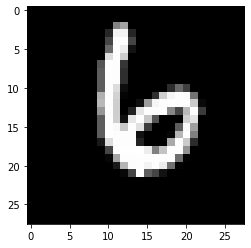

In [11]:
im_id = np.random.randint(1000)
idx = model.predict(X_test[im_id].reshape(1, -1)).argmax()
plt.imshow(x_test[im_id], cmap="gray")
print("Predicted class :", class_names[idx])
print("Actual class :", class_names[y_test[im_id]])
plt.show()

# WandB sweep

In [13]:
activation_dict = {
    "Sigmoid": Sigmoid,
    "Tanh": TanH,
    "ReLU": ReLU,
}

optim_dict = {
    "SGD": SGD,
    "Adam": Adam,
    "Nadam": Nadam,
    "Moment": Momentum,
    "RMSprop": RMSprop,
    "NAG": NAG
}

loss_dict = {
    "CategoricalCrossEntropy": CategoricalCrossEntropy,
}

accuracy_dict = {
    "Accuracy": Accuracy,
}


In [14]:
wandb.init(project="Assignment1", entity="cookie303")

sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {

        "num_layers": {
            "values": [3, 4, 5]
        },
        
        
        "num_hidden_neurons": {
            "values": [32, 64, 128, 256]
        },
        
        
        "weight_decay": {
            "values": [0, 0.0001, 0.0005, 0.001, 0.0015]
        },
        
                    
        "batch_size": {
            "values": [16, 32, 64]
        }
        
    }
}

sweep_id = wandb.sweep(sweep_config,project='Assignment1', entity='cookie303')

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▂▇▇▅█▅▆
val_loss,█▆▅▅▂▂▃▁▄▃
epoch,10
train_accuracy,0.96687
train_loss,0.10596
val_accuracy,0.95217
val_loss,0.17596


2022-02-25 17:14:32.106713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:14:32.106740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Create sweep with ID: mvcqeh0x
Sweep URL: https://wandb.ai/cookie303/Assignment1/sweeps/mvcqeh0x


In [15]:
def sweep():
    config_defaults = dict(
        epochs=10,
        num_layers=3,
        num_hidden_neurons=128,
        weight_decay=0.0005,
        learning_rate=0.0005,
        optimizer="Nadam",
        batch_size=64,
        activation="ReLU",
        initializer="xavier",
    )


    wandb.init(config=config_defaults)
    #wandb.init(project='CS6910-DeepLearningFundamentals-Assignment1', entity='rahulsundar',config = config_defaults)

    wandb.run.name = "hl_" + str(wandb.config.num_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) +\
                 "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + \
                 str(wandb.config.learning_rate) + "_bs_" + str(wandb.config.batch_size) + "_init_" + \
                 wandb.config.initializer + "_ep_" + str(wandb.config.epochs) + "_l2_" + str(wandb.config.weight_decay)
    
    CONFIG = wandb.config


    # Initialize the model
    model = Model()


    for layer in range(CONFIG.num_layers):
        # First Layer
        if layer == 0:
            model.add(Linear(
                X.shape[1], CONFIG.num_hidden_neurons, initializer=CONFIG.initializer, alpha=CONFIG.weight_decay))
            model.add(activation_dict[CONFIG.activation]())

        elif layer == CONFIG.num_layers - 1:
            model.add(Linear(CONFIG.num_hidden_neurons,
                    len(y_test_one_hot[0]), initializer=CONFIG.initializer, alpha=CONFIG.weight_decay))
            model.add(Softmax())
            
        else:
            model.add(Linear(CONFIG.num_hidden_neurons,
                    CONFIG.num_hidden_neurons, initializer=CONFIG.initializer, alpha=CONFIG.weight_decay))
            model.add(activation_dict[CONFIG.activation]())

    model.set(
        loss=CategoricalCrossEntropy(),
        optimizer=optim_dict[CONFIG.optimizer](learning_rate=CONFIG.learning_rate),
        scoring=Accuracy()
    )


    # Finalize the model
    model.setup_connections()

    model.train(X, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                epochs=CONFIG.epochs, batch_size=CONFIG.batch_size)

    test_results = model.test(X_test, y_test_one_hot)
    wandb.log({
        "test_loss":test_results['loss'],
        "test_accuracy": test_results['accuracy']
    })

In [18]:
wandb.agent(sweep_id, sweep, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: orxzazmk with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	weight_decay: 0
2022-02-25 17:20:29.496791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:20:29.496812: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.41, training_accuracy= 0.88
Validation: val_loss=0.21, val_accuracy=0.94

epoch=2
training_loss=0.18, training_accuracy= 0.95
Validation: val_loss=0.17, val_accuracy=0.95

epoch=3
training_loss=0.14, training_accuracy= 0.96
Validation: val_loss=0.16, val_accuracy=0.95

epoch=4
training_loss=0.12, training_accuracy= 0.96
Validation: val_loss=0.15, val_accuracy=0.96

epoch=5
training_loss=0.11, training_accuracy= 0.97
Validation: val_loss=0.14, val_accuracy=0.96

epoch=6
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.13, val_accuracy=0.96

epoch=7
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.13, val_accuracy=0.96

epoch=8
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.13, val_accuracy=0.96

epoch=9
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.13, val_accuracy=0.96

epoch=10
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.13, val_accuracy=0.96



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.964
test_loss,0.12388
train_accuracy,0.98002


wandb: Agent Starting Run: krsc8j8s with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0005
2022-02-25 17:21:01.352734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:21:01.352755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.37, training_accuracy= 0.89
Validation: val_loss=0.19, val_accuracy=0.94

epoch=2
training_loss=0.16, training_accuracy= 0.95
Validation: val_loss=0.16, val_accuracy=0.95

epoch=3
training_loss=0.13, training_accuracy= 0.96
Validation: val_loss=0.14, val_accuracy=0.96

epoch=4
training_loss=0.11, training_accuracy= 0.97
Validation: val_loss=0.13, val_accuracy=0.96

epoch=5
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.13, val_accuracy=0.96

epoch=6
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.12, val_accuracy=0.97

epoch=7
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.12, val_accuracy=0.97

epoch=8
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.12, val_accuracy=0.97

epoch=9
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.12, val_accuracy=0.97

epoch=10
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.12, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
test_accuracy,0.9676
test_loss,0.10721
train_accuracy,0.98202


wandb: Agent Starting Run: t4fczhsz with config:
wandb: 	batch_size: 32
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.001
2022-02-25 17:21:38.375366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:21:38.375389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.27, training_accuracy= 0.92
Validation: val_loss=0.15, val_accuracy=0.96

epoch=2
training_loss=0.12, training_accuracy= 0.96
Validation: val_loss=0.12, val_accuracy=0.96

epoch=3
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.11, val_accuracy=0.97

epoch=4
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=5
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=6


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/sandip/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/sandip/anaconda3/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandip/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 166, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/home/sandip/anaconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 114, in communicate_stop_status
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/sandip/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/sandip/anaconda3/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandip/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 148, in check_ne

training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=7
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=8
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.97

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.97

epoch=10


wandb: ERROR Run t4fczhsz errored: Error('You must call wandb.init() before wandb.log()')


training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97



wandb: Agent Starting Run: r6cqkjyn with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0.0015
2022-02-25 17:22:33.971788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:22:33.971813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.23, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=5
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=6
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=7
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇█
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.9779
test_loss,0.0682
train_accuracy,0.99031


wandb: Agent Starting Run: b93p9gkk with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0.0015
2022-02-25 17:24:14.048545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:24:14.048569: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.23, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=5
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=6
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=7
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇███▇
val_loss,█▄▃▂▂▂▁▁▁▂
epoch,10
test_accuracy,0.9759
test_loss,0.07277
train_accuracy,0.99028


wandb: Agent Starting Run: ri2ehthh with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0015
2022-02-25 17:25:38.910658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:25:38.910684: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.13, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.11, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=5
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.97

epoch=6
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97

epoch=7
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▅▅▄▇▆▆█▇
val_loss,█▆▄▃▄▂▂▂▁▁
epoch,10
test_accuracy,0.9744
test_loss,0.08176
train_accuracy,0.98848


wandb: Agent Starting Run: vizhbgkh with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0015
2022-02-25 17:27:34.820089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:27:34.820115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.14, val_accuracy=0.96

epoch=2
training_loss=0.12, training_accuracy= 0.96
Validation: val_loss=0.11, val_accuracy=0.97

epoch=3
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.11, val_accuracy=0.97

epoch=4
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=5
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=6
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=7
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=8
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=9
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=10
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇██▇
val_loss,█▄▃▃▂▃▂▁▂▁
epoch,10
test_accuracy,0.9717
test_loss,0.0895
train_accuracy,0.98119


wandb: Agent Starting Run: 9a6p1rd4 with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.0015
2022-02-25 17:33:02.306401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:33:02.306423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.98

epoch=5
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.98

epoch=6
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=7
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▇▇▇▇█▇█
val_loss,█▄▃▂▂▁▁▁▂▁
epoch,10
test_accuracy,0.9777
test_loss,0.06825
train_accuracy,0.98981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n7paytur with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0015
2022-02-25 17:34:47.170197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:34:47.170221: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.23, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=5
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=6
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97

epoch=7
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.97

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=9
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅█▆▇▇███
val_loss,█▅▄▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.9764
test_loss,0.07035
train_accuracy,0.98854


wandb: Agent Starting Run: nmhpg5u0 with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.001
2022-02-25 17:36:38.983539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:36:38.983565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.23, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=5
training_loss=0.05, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98

epoch=6
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=7
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.07, val_accuracy=0.98

epoch=8
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=9
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=10
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇███▇
val_loss,█▅▃▂▃▂▁▂▂▂
epoch,10
test_accuracy,0.9789
test_loss,0.07042
train_accuracy,0.98948


wandb: Agent Starting Run: 86ek9qrv with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.001
2022-02-25 17:38:29.538578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:38:29.538601: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=4
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=5
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.97

epoch=6
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=7
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.08, val_accuracy=0.98

epoch=8
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.07, val_accuracy=0.98

epoch=9
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.07, val_accuracy=0.98

epoch=10
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.07, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▅█▇▇█▇
val_loss,█▄▃▂▃▂▂▁▁▁
epoch,10
test_accuracy,0.9787
test_loss,0.07044
train_accuracy,0.99093


wandb: Agent Starting Run: x1p22wdb with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0001
2022-02-25 17:40:15.174307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:40:15.174330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.08, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=7
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▇▆▇▅█
val_loss,█▂▂▅▆▃▄▄▆▁
epoch,10
test_accuracy,0.979
test_loss,0.08316
train_accuracy,0.99348


wandb: Agent Starting Run: iod131dh with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0
2022-02-25 17:42:11.690112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:42:11.690139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.97

epoch=2
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.97

epoch=7
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▅▆█▆█
val_loss,█▂▃▂▄█▇▂▅▁
epoch,10
test_accuracy,0.977
test_loss,0.09472
train_accuracy,0.99319


wandb: Agent Starting Run: tdx5k4vz with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0
2022-02-25 17:43:57.682139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:43:57.682159: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.21, training_accuracy= 0.94
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.11, val_accuracy=0.97

epoch=3
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.12, val_accuracy=0.97

epoch=4
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=5
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.10, val_accuracy=0.97

epoch=6
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=7
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98

epoch=8
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98

epoch=9
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=10
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.13, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▃▃▆▆██▇▇▆
val_loss,▆▄▆▃▂▂▁▇▅█
epoch,10
test_accuracy,0.9733
test_loss,0.13182
train_accuracy,0.99209


wandb: Agent Starting Run: 9ze0bn5x with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0001
2022-02-25 17:48:58.349713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:48:58.349741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.08, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.05, training_accuracy= 0.98
Validation: val_loss=0.11, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=7
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.97

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄█▇▇▂█▇▇
val_loss,▆▂▅▂▁▂█▃█▄
epoch,10
test_accuracy,0.9766
test_loss,0.09594
train_accuracy,0.99365


wandb: Agent Starting Run: u4ib00jx with config:
wandb: 	batch_size: 64
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 5
wandb: 	weight_decay: 0
2022-02-25 17:50:49.000333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:50:49.000358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.22, training_accuracy= 0.93
Validation: val_loss=0.12, val_accuracy=0.96

epoch=2
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.09, val_accuracy=0.98

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.97

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=7
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.97

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▆▆▅█▇▆
val_loss,▆▁▁▁▄▆█▄▆█
epoch,10
test_accuracy,0.9717
test_loss,0.11315
train_accuracy,0.99341


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9kf4wrc with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0.0015
2022-02-25 17:52:39.746584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:52:39.746608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.20, training_accuracy= 0.94
Validation: val_loss=0.13, val_accuracy=0.96

epoch=2
training_loss=0.10, training_accuracy= 0.97
Validation: val_loss=0.11, val_accuracy=0.97

epoch=3
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.08, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=5
training_loss=0.07, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=6
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.08, val_accuracy=0.97

epoch=7
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=8
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=9
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=10
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇██▇▇
val_loss,█▄▃▂▃▁▁▁▂▂
epoch,10
test_accuracy,0.9723
test_loss,0.08313
train_accuracy,0.98331


wandb: Agent Starting Run: b6y5k3qx with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0
2022-02-25 17:56:42.861515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 17:56:42.861537: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.20, training_accuracy= 0.94
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.09, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.98

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=7
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.14, val_accuracy=0.97

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇▇█████
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇█▆█▇▇▅█
val_loss,▄▃▁▂▄▂▄▄█▆
epoch,10
test_accuracy,0.9779
test_loss,0.10715
train_accuracy,0.9927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 355049kj with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0
2022-02-25 18:00:29.099206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 18:00:29.099232: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.20, training_accuracy= 0.94
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.08, training_accuracy= 0.97
Validation: val_loss=0.10, val_accuracy=0.97

epoch=3
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=7
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.13, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▂▄▆▆▅▇▆█▇
val_loss,▃▂▁▃▁▅▄▃▄█
epoch,10
test_accuracy,0.9761
test_loss,0.11853
train_accuracy,0.99365


wandb: Agent Starting Run: qfrdf7v0 with config:
wandb: 	batch_size: 16
wandb: 	num_hidden_neurons: 256
wandb: 	num_layers: 3
wandb: 	weight_decay: 0
2022-02-25 18:04:00.667744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 18:04:00.667767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=1
training_loss=0.20, training_accuracy= 0.94
Validation: val_loss=0.11, val_accuracy=0.97

epoch=2
training_loss=0.08, training_accuracy= 0.97
Validation: val_loss=0.09, val_accuracy=0.97

epoch=3
training_loss=0.06, training_accuracy= 0.98
Validation: val_loss=0.09, val_accuracy=0.97

epoch=4
training_loss=0.04, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.97

epoch=5
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=6
training_loss=0.03, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.97

epoch=7
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.12, val_accuracy=0.98

epoch=8
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.10, val_accuracy=0.98

epoch=9
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98

epoch=10
training_loss=0.02, training_accuracy= 0.99
Validation: val_loss=0.11, val_accuracy=0.98



epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▃▆▅███▇
val_loss,▄▁▁▅▄▇█▃▄▅
epoch,10
test_accuracy,0.977
test_loss,0.11135
train_accuracy,0.99426


In [ ]:
wandb.finish(
    exit_code = 0,
    quiet = True
)

# Acknowledgments and References
